 #  Transfer learning model- Resnet 50 and ResNet152V2 (Intel Scene Multi-Class Image Classification)


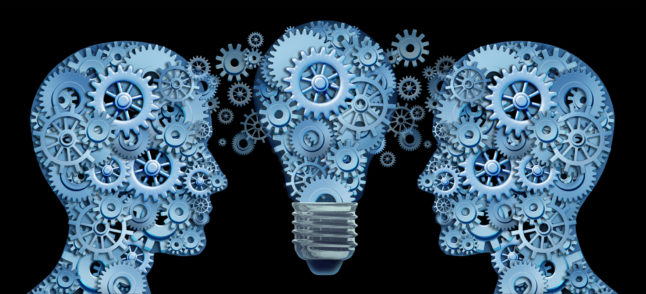

Identifying natural scenes from all around the world is an interesting computer vision problem. In this challenge, we are going to classify six different category Imges.This dataset contains about ~25k images from a wide range of natural scenes from all around the world. The task is to identify which kind of scene can the image be categorized into.

It is a 6 class problem

- Buildings
-Forests
-Mountains
- Glacier
- Street
- Sea


## Content

This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

If you check the directory under input (check the top right portion of this notebook), you can see that images are placed inside their respective classes. Separate class label csv file is not given.

So we have two choices
  1. Load images directly from ImageDataGenerator.flow_from_directory
  2. Create a function to load images from directory and create a list for class lables 

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 339M/346M [00:02<00:00, 149MB/s]
100% 346M/346M [00:02<00:00, 150MB/s]


## Given data is in Zip format. So first we have to unzip the files

In [6]:
!unzip "/content/intel-image-classification.zip"

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

## Import the libraries:

In [16]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam,SGD 
from keras.callbacks import ReduceLROnPlateau 
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout
import warnings
warnings.filterwarnings("ignore")

##Visualize some Random Images from Training set

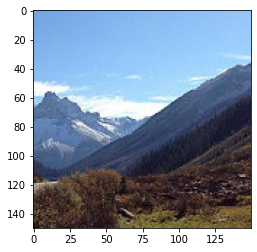

In [8]:
image = load_img("/content/seg_train/seg_train/mountain/10008.jpg")
plt.imshow(image)

## Transforms for image -augmentations


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,horizontal_flip=True,shear_range=0.2,  
    zoom_range=0.2, validation_split=0.2)

train_generator=train_datagen.flow_from_directory(
      '/content/seg_train/seg_train',
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='training'
    
)

validation_generator=train_datagen.flow_from_directory(
      '/content/seg_train/seg_train',
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='validation'
    
)

test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_directory(
    "/content/seg_test/seg_test", 
    target_size=(150,150),
    batch_size=32,
    class_mode='sparse',
    seed=2209
) 


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [10]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [12]:
#mapping encoded values to class labels
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

## Generator work

In [13]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

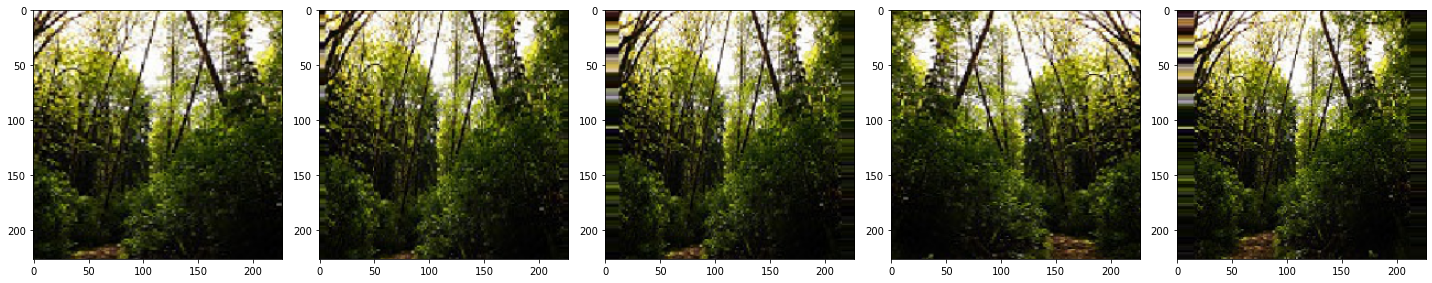

In [14]:
images = [train_generator[0][0][0] for i in range(5)]
plotImages(images)

## ResNet50

ResNet, short for Residual Networks is a classic neural network used as a backbone for many computer vision tasks. This model was the winner of ImageNet challenge in 2015. The fundamental breakthrough with ResNet was it allowed us to train extremely deep neural networks with 150+layers successfully. 

## Model Details 

Skip Connection — The Strength of ResNet
ResNet first introduced the concept of skip connection. The diagram below illustrates skip connection. The figure on the left is stacking convolution layers together one after the other. On the right we still stack convolution layers as before but we now also add the original input to the output of the convolution block. This is called skip connection 

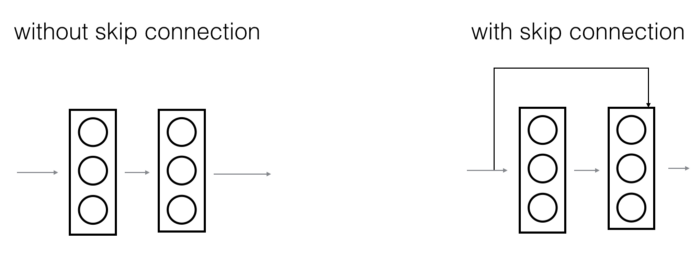

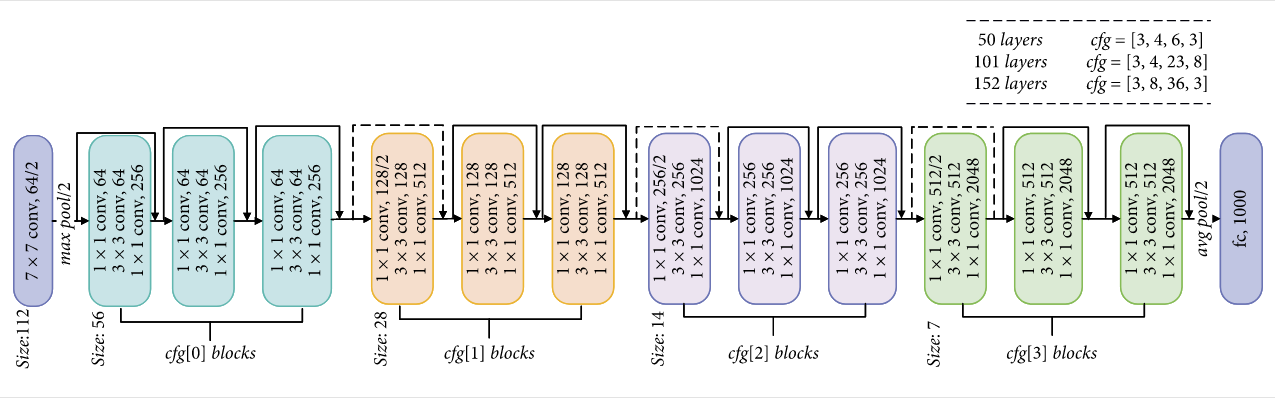

In [30]:
# Hyperparameters:
input_shape = (150,150,3)
batch_size = 32
lr = 0.001
n_class = 6
epochs =20
adam = Adam(lr = lr, beta_1 = 0.9, beta_2 =0.999,amsgrad =False,epsilon =1e-7)

In [56]:
#ReduceLROnPlateau to reduce LR 
lrr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,factor =0.25,min_lr = 0.000003, verbose =1)

In [57]:
#Creating early stopping callback
from  keras.callbacks import EarlyStopping
early_stopping =EarlyStopping(monitor = 'val_accuracy', patience=3) 
#stop the training process if there is no change in val_accuracy for 3 rounds

In [59]:
from tensorflow.keras.applications import ResNet50

#step1
# file_resnet='/kaggle/input/vgg16/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model=ResNet50( input_shape=(150,150,3),
                                  include_top=False,
                                  weights='imagenet')
#step2
for layer in pretrained_model.layers:
     layer.trainable = False
pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [60]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
x = layers.Dropout(0.3)(pretrained_model.output)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.Dense(6, activation='softmax')(x)           

model = Model( pretrained_model.input, x) 
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history=model.fit_generator(
  train_generator,
  steps_per_epoch=int(11230/64),
  epochs=50,
  validation_data=validation_generator,
  validation_steps=int(2804/64),
  
  verbose=1
)

Epoch 1/50
175/175 [==============================] - 100s 572ms/step - loss: 1.3615 - accuracy: 0.4267 - val_loss: 1.3125 - val_accuracy: 0.4535
Epoch 2/50
175/175 [==============================] - 98s 560ms/step - loss: 1.3577 - accuracy: 0.4168 - val_loss: 1.3158 - val_accuracy: 0.4495
Epoch 3/50
175/175 [==============================] - 100s 569ms/step - loss: 1.3529 - accuracy: 0.4243 - val_loss: 1.3148 - val_accuracy: 0.4426
Epoch 4/50
175/175 [==============================] - 99s 564ms/step - loss: 1.3573 - accuracy: 0.4172 - val_loss: 1.3143 - val_accuracy: 0.4455
Epoch 5/50
175/175 [==============================] - 99s 565ms/step - loss: 1.3536 - accuracy: 0.4177 - val_loss: 1.3096 - val_accuracy: 0.4491
Epoch 6/50
175/175 [==============================] - 99s 568ms/step - loss: 1.3542 - accuracy: 0.4198 - val_loss: 1.3038 - val_accuracy: 0.4451
Epoch 7/50
175/175 [==============================] - 98s 563ms/step - loss: 1.3444 - accuracy: 0.4228 - val_loss: 1.3129 - val_

## Virtualize Training

In [ ]:
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(50) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

# Prepare Evaluate Generator for Model

In [ ]:
accuracy=x.evaluate_generator(test_generator, steps=len(test_generator)//32,verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

# Test Model performance on custom data:

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def pred(path):
  test_image = image.load_img(path, target_size = (227,227))
  plt.imshow(test_image)
  test_image=np.expand_dims(test_image,axis=0)
  test_image=np.array(test_image)
  test_image=test_image/255
  prediction =np.argmax(x.predict(test_image),axis=1)
  result={0: 'buildings',1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
  return print(result[prediction[0]])

In [ ]:
pred('/content/seg_pred/seg_pred/10021.jpg')

In [ ]:
pred('/content/seg_pred/seg_pred/10045.jpg')

## ResNet152V2

In [ ]:
# Import the model  
from tensorflow.keras.applications.resnet_v2 import ResNet152V2


pre_trained_model_152 = ResNet152V2(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model_152.layers:
  layer.trainable = False
  

In [ ]:
x = layers.Dropout(0.3)(pretrained_model_152.output)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.Dense(6, activation='softmax')(x)           

model = Model( pretrained_model_152.input, x) 
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["acc"])

model.summary()

In [ ]:
history=model.fit_generator(
  train_generator,
  steps_per_epoch=int(11230/64),
  epochs=50,
  validation_data=validation_generator,
  validation_steps=int(2804/64),
  
  verbose=1
)